In [801]:
import math
import itertools
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

In [802]:
class BrownianToken():
    """
    A Brownian motion class constructor
    """
    def __init__(self, x0 = 0):
        """
        Init class
        """
        assert (type(x0) == float or type(x0) == int or x0 is None), "Expect a float or None for the initial value"
        
        self.x0 = float(x0)
    
    def gen_normal(self, n_step=100):
        """
        Generate motion by drawing from the Normal distribution
        
        Arguments:
            n_step: Number of steps
            
        Returns:
            A NumPy array with `n_steps` points
        """
        if n_step < 30:
            print("WARNING! The number of steps is small. It may not generate a good stochastic process sequence!")
        
        w = np.ones(n_step) * self.x0
        
        for i in range(1, n_step):
            # Sampling from the Normal distribution
            yi = np.random.normal()
            # Weiner process
            w[i] = w[i-1] + (yi / np.sqrt(n_step))
        
        return w
    
    def token_price(
                    self,
                    s0=100,
                    sigma=0.68,
                    deltaT=52,
                    dt=0.1
                    ):
        """
        Models a token price S(t) using the Weiner process W(t) as
        `S(t) = S(0).exp{sigma.W(t)}`
        
        Arguments:
            s0: Iniital token price, default 100
            sigma: 'Volatility' of the token, default 1
            deltaT: The time period for which the future prices are computed, default 52 (as in 52 weeks)
            dt (optional): The granularity of the time-period, default 0.1
        
        Returns:
            s: A NumPy array with the simulated token prices over the time-period deltaT
        """
        n_step = int(deltaT / dt)
        time_vector = np.linspace(0, deltaT, num = n_step)
        # Forcefully set the initial value to zero for the token price simulation
        self.x0=0
        # Weiner process (calls the `gen_normal` method)
        weiner_process = sigma * self.gen_normal(n_step)
        # take the exponent of the time series, and multiply it by the initial token price
        s = s0*(np.exp(weiner_process))
        
        return s

In [803]:
def plot_token_price(s0, sigma, deltaT, dt, n):
    """
    Plots token price for multiple scenarios
    """
    plt.figure(figsize=(9,4))
    for i in range(n):
        plt.plot(b.token_price(s0 = s0,
                               sigma = sigma,
                               deltaT = deltaT,
                               dt = dt))
    plt.legend(['Scenario-'+str(i) for i in range(1,n+1)],
               loc='upper left')
    plt.hlines(y=100, xmin=0, xmax=520,
               linestyle='--',color='k')
    plt.show()

In [804]:
def single_pos_data_from_arb(token_prices, gamma, price, amount):
    assert gamma < 1 and 0 <= gamma
    count = 0
    reserves = amount
    a = False
    for i in range(len(token_prices)):
        if token_prices[i] < price * (1 - gamma) and a:
            a = False
            reserves = reserves / ( price * (1 - gamma) )
            count += 1
        elif token_prices[i] > price / (1 - gamma) and not a:
            a = True
            reserves = reserves / ((1 - gamma) / price)
            count += 1

    #TODO: need to validate assumptions for each of these calculations
    flips = int(count / 2)
    pos_growth = (1 / (1 - gamma) ** 2) ** flips
    pos_value = min(price / (1 - gamma), token_prices[len(token_prices) - 1])

    return pos_value * pos_growth, pos_growth, flips, reserves, a




In [805]:
def plot_distribution(s0, sigma, deltaT, dt, gamma, amount, n):
    b = BrownianToken(s0)
    x = []
    num_increments = deltaT / dt
    for i in range(n):
        token_prices = b.token_price(s0 = s0,
                                    sigma = sigma,
                                    deltaT = deltaT,
                                    dt = dt)
        # Benchmarked against 100% USD
        #x.append(single_pos_data_from_arb(token_prices, gamma, s0, amount)[0] - s0)
        # Benchmarked against 100% ETH
        #.append(single_pos_data_from_arb(token_prices, gamma, s0, amount)[0] - token_prices[len(token_prices) - 1])
        # Benchmarked against 50/50 ETH/USD
        #ETH_USDC = (s0 / 2) + (token_prices[len(token_prices) - 1] / 2)
        #x.append(single_pos_data_from_arb(token_prices, gamma, s0, amount)[0] - ETH_USDC )
    plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
    plt.hist(x, bins=50)
    plt.gca().set(title= 'Single Position Start Price: {}'.format(s0), ylabel='Frequency', xlabel="End Position PnL 1 year")
    print(np.average(x))

-1055.0655863518134


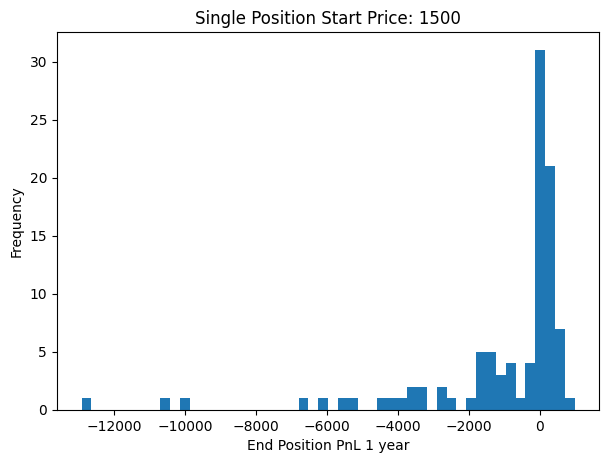

In [806]:
amount = 1
s0 = 1500
b = BrownianToken(s0)
deltaT = 365
dt = .1
n = 100
ETH_daily_vol = .05
#sigma = annual vol
sigma = ETH_daily_vol * np.sqrt(deltaT)

stock_prices = b.token_price(s0 = s0,
              sigma = sigma,
              deltaT = deltaT,
              dt = dt)

#print(stock_prices)
#print(single_pos_gains_from_arb(stock_prices, .01, s0, amount))

#plot_token_price(s0, sigma, deltaT, dt, n)
plot_distribution(s0, sigma, deltaT, dt, .01, amount, n)
